# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

This notebook is based on a template provided for implementing a Traffic Sign Recognition Classifier in stages 

> **Note**: A HTML file of this notebook, and a write up that covers all the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project is also availbale in this repository.


---
## Step 0: Load The Data

In [29]:
# Import all the required libraries

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import cv2
import tensorflow as tf
import tensorflow.contrib.layers as layers
from tensorflow.contrib.layers import flatten
import pickle
from sklearn.utils import shuffle
import random
from tqdm import tqdm

In [30]:
# Load pickled data
# These Pickle files are not placed in this repository.

training_file = "../data/train.p"
validation_file= "../data/valid.p"
testing_file = "../data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

The pickle file	:Train has 4 elements.
keys		: dict_keys(['coords', 'labels', 'features', 'sizes'])
labels[0]	: 41
features[0]	: (32, 32, 3)


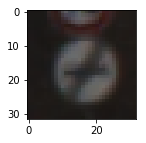

In [31]:
# Understanding the Pickle files:

print("The pickle file\t:Train has {} elements.".format(len(train)))
print("keys\t\t:", train.keys())
print("labels[0]\t:", train['labels'][0])
print("features[0]\t:", train['features'][0].shape)
plt.figure(figsize=(2,2))
plt.imshow(train['features'][0])

In [32]:
# Assigning the pickle features and labels to variables

X_train, y_train = train['features'], train['labels']
X_valid, y_valid = valid['features'], valid['labels']
X_test, y_test   = test['features'], test['labels']

print("Image Shape: {}".format(X_train[0].shape))
print()
print("Training Set   :{} samples".format(len(X_train)))
print("Validation Set :{} samples".format(len(X_valid)))
print("Test Set       :{} samples".format(len(X_test)))

Image Shape: (32, 32, 3)

Training Set   :34799 samples
Validation Set :4410 samples
Test Set       :12630 samples


In [33]:
# Here we read the CSV file, that contains the description of each lables

Traffic_signs = pd.read_csv("signnames.csv", index_col="ClassId", usecols=["ClassId", "SignName"], squeeze = True)
print(Traffic_signs.head())

ClassId
0    Speed limit (20km/h)
1    Speed limit (30km/h)
2    Speed limit (50km/h)
3    Speed limit (60km/h)
4    Speed limit (70km/h)
Name: SignName, dtype: object


---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image.

**THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**


### Basic Summary of the Data Set Using Pandas and Matplotlib

In [34]:
# Number of training examples
n_train = len(X_train)

# Number of validation examples
n_validation = len(X_valid)

# Number of testing examples.
n_test = len(X_test)

# Shape of an traffic sign image
image_shape = (X_train[0].shape)

# unique classes/labels there are in the dataset.
unique_labels, unique_labels_indices, unique_labels_counts= np.unique(y_train, return_index=True,return_counts=True)

n_classes = len(unique_labels)

print("#"*100)
print("Number of training examples =", n_train)
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)
print("#"*100)
print("The unique lables found are :\n", unique_labels)
print("#"*100)
print("Corresponding Unique values are found at indices :\n", unique_labels_indices)
print("#"*100)

####################################################################################################
Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43
####################################################################################################
The unique lables found are :
 [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42]
####################################################################################################
Corresponding Unique values are found at indices :
 [ 9960  2220 31439  5370  6810 12360 21450 23730 15870 11040 17130  8580
 27329 21810 29219 29909  5010 30449 20370  6630 25950 25680  4500  1770
 10800 33449  1230 10350 26849 10560 25020   210 10140 26250 20010 18930
   900  4830 14010 25410  4200     0  9750]
#########################################################

### Exploratory visualization of the dataset

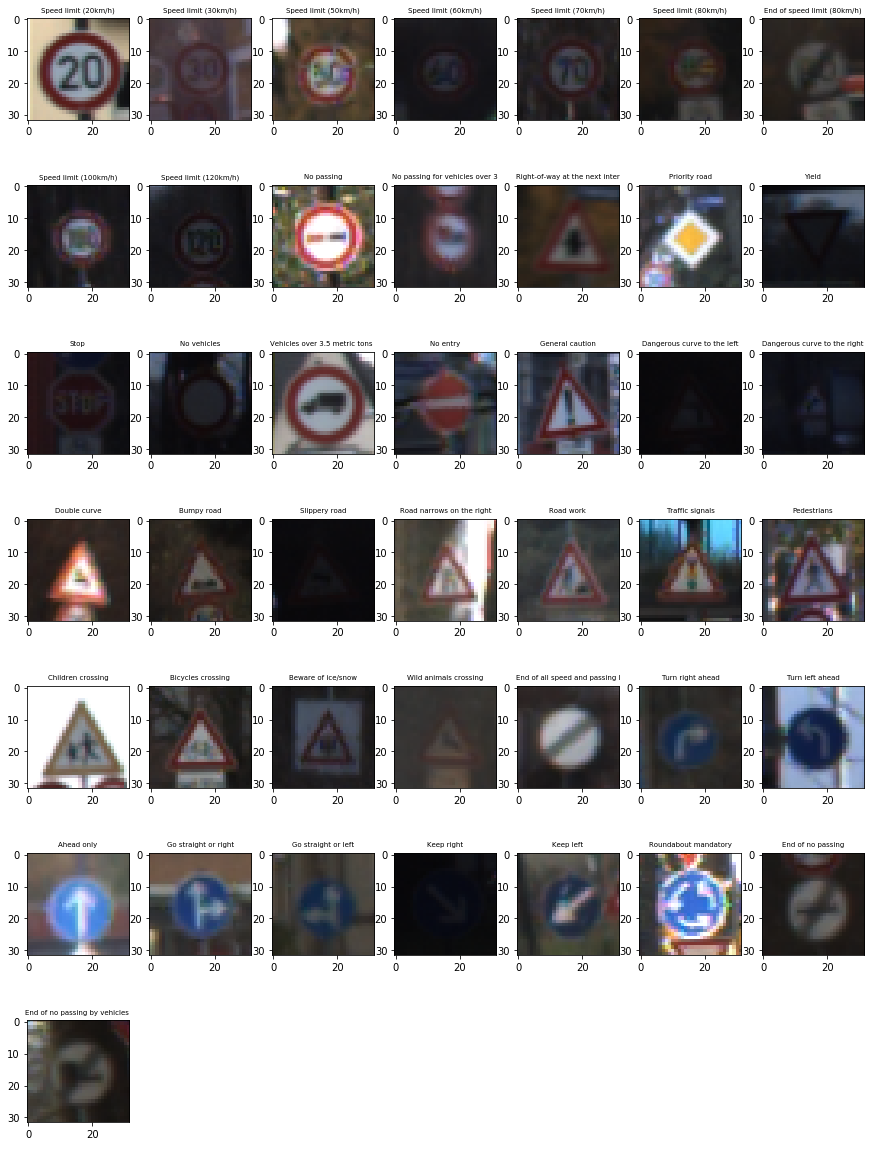

In [35]:
%matplotlib inline

# Unique signs, corresponding to the unique lables.
unique_images = X_train[unique_labels_indices]

# Columns and rows for visualisation
plot_columns = 7
plot_rows = int((n_classes/plot_columns))+1

# Plots of all the unique images
f, subplot_tuples = plt.subplots(plot_rows,plot_columns,figsize=(15,(3*plot_rows)))

unique_image_count = 0

for i in range(plot_rows):
    for j in range(plot_columns):
        if unique_image_count < n_classes :
            subplot_tuples[i][j].imshow(unique_images[unique_image_count])
            subplot_tuples[i][j].set_title(Traffic_signs[unique_image_count][:30], fontsize=7)
            unique_image_count = unique_image_count+1
        else :
            subplot_tuples[i][j].axis('off')


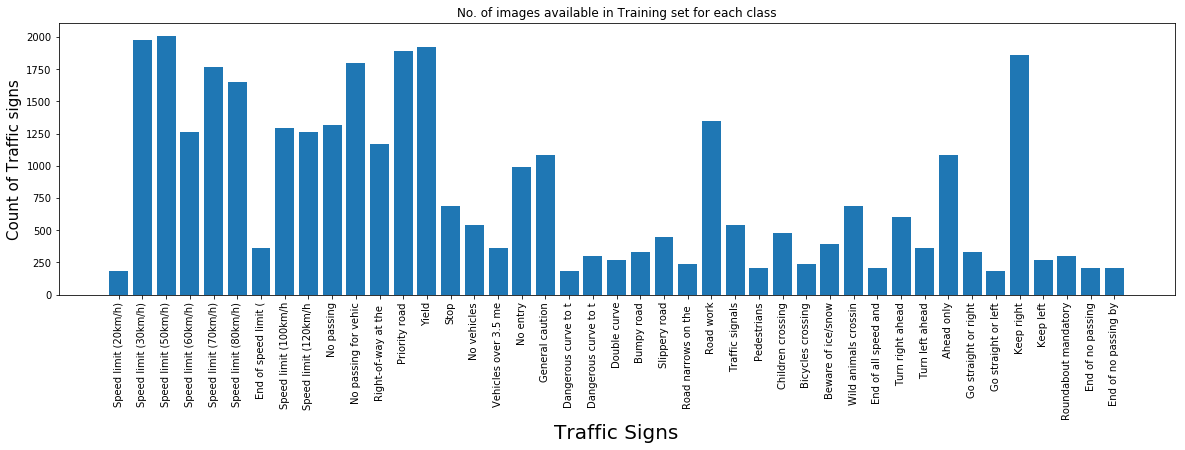

In [36]:
# Bar chart of number of test images available for each class

index = np.arange(len(Traffic_signs))
plt.figure(figsize=(20,5))
plt.bar(index, unique_labels_counts,)
plt.xlabel('Traffic Signs', fontsize=20)
plt.ylabel('Count of Traffic signs', fontsize=15)
plt.xticks(index, Traffic_signs.apply(lambda x : x[:20]), fontsize=10, rotation=90)
plt.title('No. of images available in Training set for each class')
plt.show()

### As we can see, much of the images are in darker shade. And the samples of many images are fewer in count, while others have a higher count.

### This will lead to our model to make decisions biased towards signs with higher number of samples.

### To overcome this, we shall normalize the images in all three channels, and produce higher number of augmented copies for images with lesser samples

----

## Step 2: Design and Test a Model Architecture

This contains a deep learning model that learns to recognize traffic signs, using the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is used as the starting point. 

The Number of classes is changed, and few droupouts are added to overcome overfitting.

With the LeNet-5 solution from the lecture, we expect a validation set accuracy of about 0.89.
**To meet specifications, the validation set accuracy need to be at least 0.93.**



### Pre-process the Data Set

The images vary in brightness, with should not be fed to the CNN model. This will lead the model to account brighness also as one of the parameter.

To overcome this, we can use [histogram normalisation](https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html) across all three channels.

The image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data. 

> Normalizing the images, before augmenting them will lead to multiple copies of same image. This ultimately lead to overfitting of the model, producing 99% of accuracy in training set, but less than 80% of accuracy in validation set. Hence, normalization is moved after the augmentation step. 


In [37]:
# preprocess image

def preprocess_image(rgb_image_array):
    
    for rgb_image in rgb_image_array:
        # ref : https://docs.opencv.org/3.1.0/d5/daf/tutorial_py_histogram_equalization.html
        rgb_image[:,:,0] = cv2.equalizeHist(rgb_image[:,:,0])
        rgb_image[:,:,1] = cv2.equalizeHist(rgb_image[:,:,1])
        rgb_image[:,:,2] = cv2.equalizeHist(rgb_image[:,:,2])
        #rgb_image =  ((rgb_image.astype(float))-128)/128
    
    return rgb_image_array

X_train = preprocess_image(X_train)
X_valid = preprocess_image(X_valid)
X_test = preprocess_image(X_test)

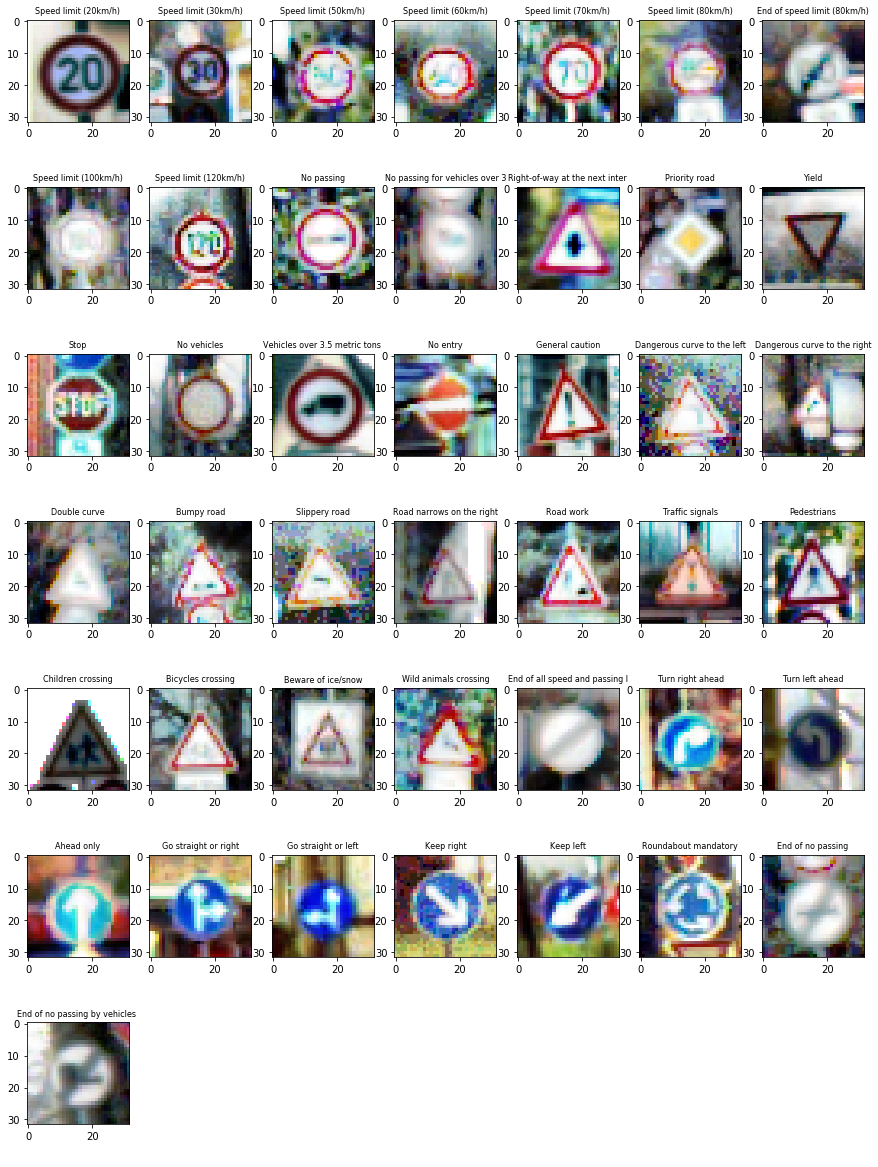

In [38]:
# Unique signs, corresponding to the unique lables.
unique_images = X_train[unique_labels_indices]

# Columns and rows for visualisation
plot_columns = 7
plot_rows = int((n_classes/plot_columns))+1

# Plots of all the unique images
f, subplot_tuples = plt.subplots(plot_rows,plot_columns,figsize=(15,(3*plot_rows)))

unique_image_count = 0

for i in range(plot_rows):
    for j in range(plot_columns):
        if unique_image_count < n_classes :
            subplot_tuples[i][j].imshow(unique_images[unique_image_count])
            subplot_tuples[i][j].set_title(Traffic_signs[unique_image_count][:30], fontsize=8)
            unique_image_count = unique_image_count+1
        else :
            subplot_tuples[i][j].axis('off')

### Here, new set of augmented images are produced, using [affine transform](https://docs.opencv.org/3.4.3/d4/d61/tutorial_warp_affine.html)
> The size of Training set is increased 4 times, and the count of augmented images for each sample is based on their original count in training set

> This step takes more time than the training of neural netowrk. As parallelism cannot be exploited for producing augmented images, each and every image are generated sequentially, and appended to the training set. This is faster in bare metal, than on cloud workspace. Using the GPU instance that Udacity provides (for training the models) doesnot help for this purpose. This will exhaust the GPU limit that we have.

| **Workspace used**        	| **Time Taken**		| 
|:-----------------------------:|:---------------------:| 
| Bare metal (Laptop)       	| 5 hours(approx.)  	| 
| Udacity GPU instance      	| 6 hours(approx.)     	|
| Udacity Normal Cloud Workspace| 9 hours(approx.)		|

> So it's a good idea to generate these images, store the images in a pickle file (~400 mb), upload it to the udacity workspace and start the GPU instance


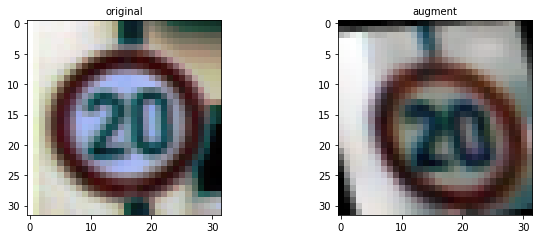

In [40]:
# Add augmented images for training

# Flags to decide how to get the training set with augmented images

generate_augmented_images = False
unpickle_augmented_images = True
no_augmented_images = False

X_train_bkup = X_train
y_train_bkup = y_train

def display_side_by_side(image1, image1_name, image2, image2_name,_figsize=(8, 3)):
    """
    Display given 2 images side by side.
    """
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=_figsize)
    f.tight_layout()
    ax1.imshow(image1)
    ax1.set_title(image1_name, fontsize=10)
    ax2.imshow(image2)
    ax2.set_title(image2_name, fontsize=10)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

def augment_training_set(train_features, train_lables, increase_times=4):
    
    unique_labels, unique_labels_indices, unique_labels_counts= np.unique(y_train, return_index=True,return_counts=True)
    n_classes = len(unique_labels)
    unique_images = X_train[unique_labels_indices]
    
    def get_random_image_for_given_class(class_name):
        class_indices = np.where( y_train == class_name)[0]   # This returns a tuple of indices and datatype, hence the [0]
        X_class = X_train[class_indices]
        return X_class[random.randint(0,len(X_class)-1)]
    
    def get_augment_images_requiremnt_count(class_name):
        total_samples = len(y_train)
        final_samples = total_samples * increase_times
        present_count = unique_labels_counts[np.where(unique_labels==class_name)[0][0]]
        return int(final_samples/n_classes)-present_count
        
    def affine_transform_and_rotate(src):
        # Refer : https://docs.opencv.org/3.4.3/d4/d61/tutorial_warp_affine.html
        # apply affine transform
        srcTri = np.array( [[0, 0], [src.shape[1] - 1, 0], [0, src.shape[0] - 1]] ).astype(np.float32)
        
        def rand_float():
            #return 0.75
            return float(random.randint(80,100))/100
        def rand_int():
            return random.randint(1,5)
            
        dstTri = np.array( [[0, 0], [src.shape[1]*rand_float(), rand_int()], [rand_int(), src.shape[0]*rand_float()]] ).astype(np.float32)
        warp_mat = cv2.getAffineTransform(srcTri, dstTri)
        warp_dst = cv2.warpAffine(src, warp_mat, (src.shape[1], src.shape[0]))
        # Rotating the image after Warp
        center = (warp_dst.shape[1]//2, warp_dst.shape[0]//2)
        angle = random.randint(-20,20)
        scale = float(random.randint(90,120))/100
        rot_mat = cv2.getRotationMatrix2D( center, angle, scale )
        warp_rotate_dst = cv2.warpAffine(warp_dst, rot_mat, (warp_dst.shape[1], warp_dst.shape[0]))
        return warp_rotate_dst
    
    for each_class in unique_labels:
        for i in range(get_augment_images_requiremnt_count(each_class)):
            print ("generating augmented image {} of {} for class{}".format(i,get_augment_images_requiremnt_count(each_class),each_class))
            generated_image = (affine_transform_and_rotate(get_random_image_for_given_class(each_class)))
            train_features = np.append(train_features,[generated_image],axis=0)
            train_lables = np.append(train_lables,[each_class])

        
    pickle_out = open("../data/Y_generated_2_feb_v2_local.pickel","wb")
    pickle.dump(y_train2, pickle_out)
    pickle_out.close()
    pickle_out = open("../data/X_generated_2_feb_v2_local.pickel","wb")
    pickle.dump(X_train2, pickle_out)
    pickle_out.close()
    
    display_sample = random.randint(0,40)
    original = get_random_image_for_given_class(unique_labels[display_sample])
    print(get_augment_images_requiremnt_count(unique_labels[display_sample]))
    augment = (affine_transform_and_rotate(original))
    display_side_by_side(original, "original", augment, "augment")
    
    
    return (train_features, train_lables)


def read_from_pickle(path1, path2):
    n_original_images = len(X_train)
    display_sample = random.randint(0,n_original_images)
    with open(path1, mode='rb') as f:
        out1 = pickle.load(f)
    with open(path2, mode='rb') as f:
        out2 = pickle.load(f)
        display_side_by_side(out1[9960], "original", out1[34800], "augment")
    return out1,out2

if generate_augmented_images:
    X_train, y_train = augment_training_set(X_train, y_train)
    
elif unpickle_augmented_images:
    X_train, y_train = read_from_pickle("../data/X_generated_2_feb_v2_local.pickel","../data/Y_generated_2_feb_v2_local.pickel")
    
else:
    print("No Augmentation is done ..!")

#X_train2, y_train2 = augment_training_set(X_train, y_train)
#X_train2, y_train2 = read_from_pickle("./X_generated_4_feb_v4_cloud.p","./Y_generated_4_feb_v4_cloud.p")

### Now, normalization around mean zero can be applied on all the image samples in train, valid and test sets.


In [41]:
print(X_train.shape,y_train.shape)

(139191, 32, 32, 3) (139191,)


In [42]:
def normalise_around_zero(rgb_image_array):
    rgb_image_array = (rgb_image_array.astype(float)-128)/128
    return rgb_image_array

X_train = normalise_around_zero(X_train)
X_valid = normalise_around_zero(X_valid)
X_test = normalise_around_zero(X_test)

In [43]:
print(X_train[0][0][0])
print(X_valid[0][0][0])
print(X_test[0][0][0])

[-0.609375  -0.515625  -0.1796875]
[-0.4140625 -0.5703125 -0.6015625]
[ 0.3671875  0.734375   0.8125   ]


### The below cell shows the ratio of availbale images for each class in training set

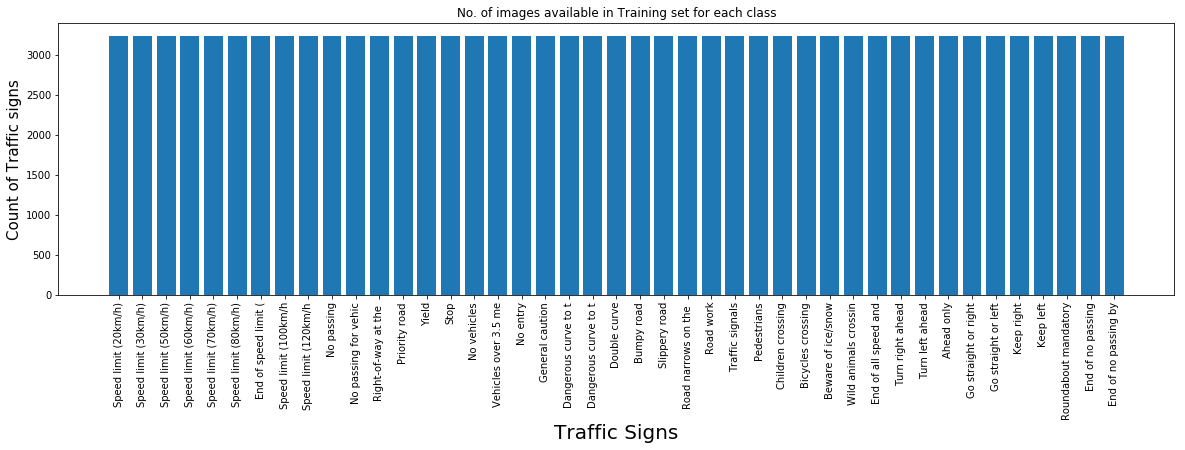

In [44]:
# Bar chart of number of test images available for each class

unique_labels, unique_labels_indices, unique_labels_counts= np.unique(y_train, return_index=True,return_counts=True)
n_classes = len(unique_labels)
unique_images = X_train[unique_labels_indices]
index = np.arange(len(Traffic_signs))
plt.figure(figsize=(20,5))
plt.bar(index, unique_labels_counts,)
plt.xlabel('Traffic Signs', fontsize=20)
plt.ylabel('Count of Traffic signs', fontsize=15)
plt.xticks(index, Traffic_signs.apply(lambda x : x[:20]), fontsize=10, rotation=90)
plt.title('No. of images available in Training set for each class')
plt.show()

## Model Architecture - **LeNet**


> The Lenet Architecture used in classroom for CNN, is used here. Few Dropouts are added for reducing the problem of overfitting

| Layer             |     Description	                          |
|:-----------------:|:-------------------------------------------:|
| Input         	| 32x32x3 RGB image					          |
| Convolution 5x5   | 1x1 stride, valid padding, outputs 28x28x6  |
| RELU				| outputs 28x28x6							  |
| Max Pooling 2x2   | 2x2 stride, valid padding, outputs 14x14x6  |
| Convolution 5x5   | 1x1 stride, valid padding, outputs 10x10x16 |
| RELU			    | outputs 10x10x16							  |
| Max Pooling 2x2   | 2x2 stride, valid padding, outputs 5x5x16   |
| Flatten       	| outputs 400                                 |
| Fully Connected   | outputs 120                                 |
| Fully Connected   | outputs 84                                  |
| Fully Connected   | outputs 43                                  |

In [45]:
#conv1 = None
#conv2 = None


def LeNet(x):  
    # Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
    mu = 0
    sigma = 0.1
    
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    conv1_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 3, 6), mean = mu, stddev = sigma))
    conv1_b = tf.Variable(tf.zeros(6))
    conv1   = tf.nn.conv2d(x, conv1_W, strides=[1, 1, 1, 1], padding='VALID') + conv1_b

    # Activation.
    conv1 = tf.nn.relu(conv1)

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    conv1 = tf.nn.max_pool(conv1, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Layer 2: Convolutional. Output = 10x10x16.
    conv2_W = tf.Variable(tf.truncated_normal(shape=(5, 5, 6, 16), mean = mu, stddev = sigma))
    conv2_b = tf.Variable(tf.zeros(16))
    conv2   = tf.nn.conv2d(conv1, conv2_W, strides=[1, 1, 1, 1], padding='VALID') + conv2_b
    
    # Activation.
    conv2 = tf.nn.relu(conv2)

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    conv2 = tf.nn.max_pool(conv2, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    fc0   = flatten(conv2)
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    fc1_W = tf.Variable(tf.truncated_normal(shape=(400, 120), mean = mu, stddev = sigma))
    fc1_b = tf.Variable(tf.zeros(120))
    fc1   = tf.matmul(fc0, fc1_W) + fc1_b
    
    # Activation.
    fc1    = tf.nn.relu(fc1)
    fc1 = tf.nn.dropout(fc1,keep_prob)

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    fc2_W  = tf.Variable(tf.truncated_normal(shape=(120, 84), mean = mu, stddev = sigma))
    fc2_b  = tf.Variable(tf.zeros(84))
    fc2    = tf.matmul(fc1, fc2_W) + fc2_b
    
    # Activation.
    fc2    = tf.nn.relu(fc2)
    fc2    = tf.nn.dropout(fc2,keep_prob)

    # Layer 5: Fully Connected. Input = 84. Output = 43.
    fc3_W  = tf.Variable(tf.truncated_normal(shape=(84, 43), mean = mu, stddev = sigma))
    fc3_b  = tf.Variable(tf.zeros(43))
    logits = tf.matmul(fc2, fc3_W) + fc3_b
    
    return logits, conv1, conv2

In [46]:
x = tf.placeholder(tf.float32, (None, 32, 32,3))
y = tf.placeholder(tf.int32, (None))
keep_prob = tf.placeholder(tf.float32)
one_hot_y = tf.one_hot(y, 43, on_value=1,off_value=0)

### Training, Validation and Testing of the Model

> Initially, the model was terribly overfitting, due to mistake done in preprocessing. Hwever, this was solved by reordering the pre-processing steps

In [47]:
rate = 0.001    #Learning rate of the model

logits, conv1_bkup, conv2_bkup = LeNet(x)
cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=one_hot_y, logits=logits)
loss_operation = tf.reduce_mean(cross_entropy)
optimizer = tf.train.AdamOptimizer(learning_rate = rate)
training_operation = optimizer.minimize(loss_operation)

In [48]:
correct_prediction = tf.equal(tf.argmax(logits, 1), tf.argmax(one_hot_y, 1))
accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))
saver = tf.train.Saver()

def evaluate(X_data, y_data):
    num_examples = len(X_data)
    total_accuracy = 0
    sess = tf.get_default_session()
    for offset in range(0, num_examples, BATCH_SIZE):
        batch_x, batch_y = X_data[offset:offset+BATCH_SIZE], y_data[offset:offset+BATCH_SIZE]
        accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 1.0})
        total_accuracy += (accuracy * len(batch_x))
    return (total_accuracy / num_examples)

  0%|          | 0/100 [00:00<?, ?it/s]

Training...



100%|██████████| 100/100 [24:22<00:00, 14.35s/it]


EPOCHS 100 :  
VALIDATION SET ACCURACY = 0.976  (Rubric 7)   
training set accuracy   = 0.995


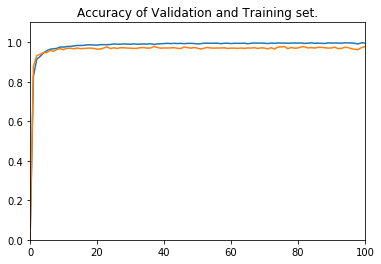

In [49]:
# flag to set whether the training should be executed from scratch.

train_from_scratch = True
num_examples = len(X_train)

def save_trained_model(sess):
    saver = tf.train.Saver()
    saver.save(sess, "./saved_model.model")
    
def fetch_train_model(sess):
    saver = tf.train.Saver()
    saver.restore(sess,"./saved_model.model" )


EPOCHS = 100
BATCH_SIZE = 128


with tf.Session() as sess:
    if train_from_scratch:
        sess.run(tf.global_variables_initializer())
        validation_accuracy = [0]
        training_accuracy = [0]
        print("Training...")
        print()
        for i in tqdm(range(EPOCHS)):
            X_train, y_train = shuffle(X_train, y_train)
            for offset in range(0, num_examples, BATCH_SIZE):
                end = offset + BATCH_SIZE
                batch_x, batch_y = X_train[offset:end], y_train[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y, keep_prob: 0.7})

            validation_accuracy.append(evaluate(X_valid, y_valid))
            training_accuracy.append(evaluate(X_train, y_train))
        print("EPOCHS {} :".format(EPOCHS), 
              " \nVALIDATION SET ACCURACY = {:.3f}".format(validation_accuracy[-1]), " (Rubric 7) ",
              " \ntraining set accuracy   = {:.3f}".format(training_accuracy[-1]))
        save_trained_model(sess)
        plt.plot(training_accuracy)
        plt.plot(validation_accuracy)
        plt.ylim(0,1.1)
        plt.xlim(0,EPOCHS)
        plt.title("Accuracy of Validation and Training set.")
    
    else:
        fetch_train_model(sess)
        print("training set   : = {:.3f}".format(evaluate(X_train, y_train)))
        print("Validation set : = {:.3f}".format(evaluate(X_valid, y_valid)))
        


In [21]:
with tf.Session() as sess:
    fetch_train_model(sess)
    print("testing set : = {:.3f}".format(evaluate(X_test, y_test)))

INFO:tensorflow:Restoring parameters from ./saved_model.model
testing set : = 0.945


---

## Step 3: Testing the Model on New Images

To give ourself more insight into how our model is working, five pictures of German traffic signs are downloaded from the web and used in our model to predict the traffic sign type.


### Load and Output the Images

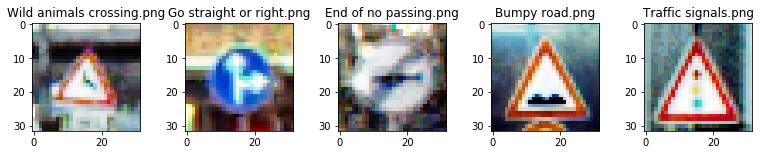

In [22]:
import os
web_images_names = os.listdir("./new_images/")

web_image_array = []

for i in range(len(web_images_names)):
    web_images_names[i] = "./new_images/"+web_images_names[i]

f, plot_tuple = plt.subplots(1, len(web_images_names), figsize=(len(web_images_names)*2,2))
f.tight_layout()
for i in range(len(web_images_names)):
    web_image_array.append(cv2.imread(web_images_names[i]))
    plot_tuple[i].imshow(plt.imread(web_images_names[i]))
    plot_tuple[i].set_title(web_images_names[i][13:])

plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)

### Predicting the Sign Type for Each Image

In [23]:
web_image_array1 = np.asarray(web_image_array)
preprocessed_web_image_array = preprocess_image(web_image_array1)
norm_web_image_array = normalise_around_zero(preprocessed_web_image_array)
y_web = np.asarray([31, 36, 41, 22, 26])

with tf.Session() as sess:
    fetch_train_model(sess)
    Z = logits.eval(feed_dict={x: norm_web_image_array, y: y_web, keep_prob:1.0})
    y_pred = np.argmax(Z, axis=1)
    predictions_array = []
    for i in range(len(y_pred)):
        predictions_array.append(Traffic_signs[y_pred[i]])
        print(" Prediction of image :", i+1, " -> ", Traffic_signs[y_pred[i]], y_pred[i])

INFO:tensorflow:Restoring parameters from ./saved_model.model
 Prediction of image : 1  ->  Wild animals crossing 31
 Prediction of image : 2  ->  No entry 17
 Prediction of image : 3  ->  End of no passing 41
 Prediction of image : 4  ->  Bumpy road 22
 Prediction of image : 5  ->  General caution 18


### Analyze Performance

In [24]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

correct_prediction_counter = 0
for i in range(len(web_images_names)):
    if web_images_names[i][13:-4] == predictions_array[i]:
        correct_prediction_counter = correct_prediction_counter +1
        
print ("Accuracy of the predictions on new images is {}% ".format((correct_prediction_counter/len(web_images_names))*100))

Accuracy of the predictions on new images is 60.0% 


> As we can see, the performance on these 5 images is **only 60%** , but the performance of our model in **training set is 99.5**, **validation set is 97.6**, and **testing set is 94.5**

### Performance on New Images:

> The performance of these new 5 images are poor than the test or training set images.  This is mainly because, the signs with incorrect predictions look are more or less similar to the signs of predicted outcome.

> **Genaral Caution** looks similar to **Traffic signal**

> **Go straight or right** looks similar to **no entry**

This can be solved by using a huge dataset for training the model.

### Output of Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 



In [25]:
### top five softmax probabilities for the predictions on the German traffic sign images found on the web. 

with tf.Session() as sess:
    fetch_train_model(sess)
    top5 = sess.run(tf.nn.top_k(tf.nn.softmax(logits),5), feed_dict={x:norm_web_image_array, y: y_web, keep_prob:1.0})
    print(top5)

INFO:tensorflow:Restoring parameters from ./saved_model.model
TopKV2(values=array([[  9.99998569e-01,   1.20522213e-06,   2.54582943e-07,
          1.81966248e-10,   1.17005669e-10],
       [  9.99935985e-01,   5.42353846e-05,   9.67614415e-06,
          5.42193703e-08,   4.74677364e-08],
       [  9.99999881e-01,   1.75215519e-07,   1.55649094e-08,
          7.23422788e-09,   2.29438495e-12],
       [  1.00000000e+00,   1.53973634e-09,   4.69428073e-11,
          3.82636284e-12,   4.56674141e-13],
       [  8.30895364e-01,   1.69104710e-01,   6.68032407e-10,
          7.42455403e-12,   1.00743133e-12]], dtype=float32), indices=array([[31, 39, 37, 19,  0],
       [17, 14, 12, 34, 18],
       [41, 42, 32,  6, 12],
       [22, 15, 29, 20, 38],
       [18, 26, 37, 24, 11]], dtype=int32))


## VISUALIZATIONS OF THE SOFTMAX PROBABILITIES

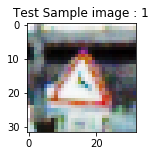

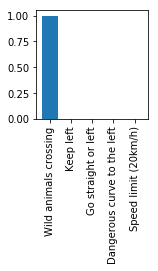

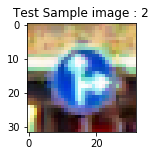

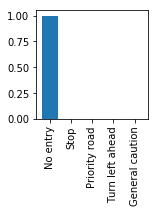

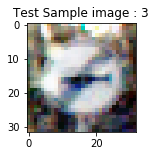

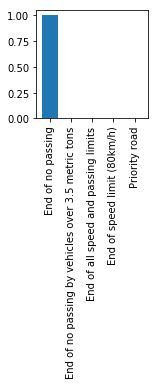

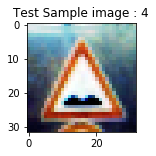

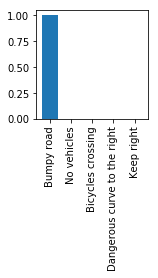

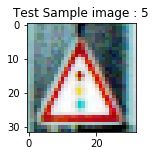

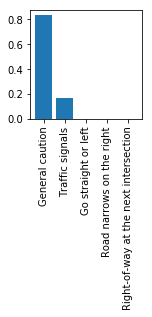

In [26]:
def top5_softmax(image, softmax, indeces, i):
    #f, plot_tuple = plt.subplots(1, 2, figsize=(4,4))
    #f.tight_layout()
    plt.figure(figsize=(2,2))
    plt.title("Test Sample image : "+ str( i+1))
    plt.imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))
    label_signs = []
    for i in range(len(indeces)):
        label_signs.append(Traffic_signs[indeces[i]])
    index = np.arange(len(label_signs))
    plt.figure(figsize=(2,2))
    plt.bar(index, softmax,)
    
    plt.xticks(index, label_signs, fontsize=10, rotation=90)
    plt.show()
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    
for i in range(len(top5[0])):
    top5_softmax(web_image_array[i], top5[0][i], top5[1][i], i)

---

## Step 4 : Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [50]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1 ,plt_num=1):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    with tf.Session() as sess:
        fetch_train_model(sess)
        activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
        featuremaps = activation.shape[3]
        plt.figure(plt_num, figsize=(15,15))
        for featuremap in range(featuremaps):
            plt.subplot(6,8, featuremap+1) # sets the number of feature maps to show on each row and column
            plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
            if activation_min != -1 & activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
            elif activation_max != -1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
            elif activation_min !=-1:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
            else:
                plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

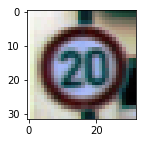

INFO:tensorflow:Restoring parameters from ./saved_model.model


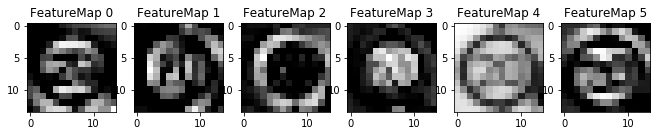

INFO:tensorflow:Restoring parameters from ./saved_model.model


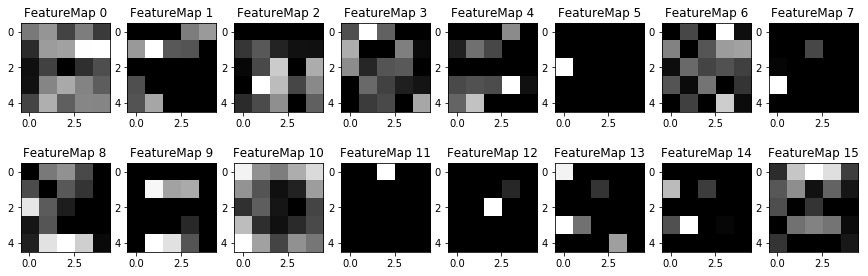

In [51]:
plt.figure(figsize=(2,2))
plt.imshow(X_train_bkup[9960])
plt.show()
outputFeatureMap(X_train_bkup[9960:9961,:,:,:],conv1_bkup)
plt.show()
outputFeatureMap(X_train_bkup[9960:9961,:,:,:],conv2_bkup)
plt.show()